<a href="https://colab.research.google.com/github/FedericaBellini22/CVProject-2024/blob/main/resnet50_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Extract the tar.gz file
!tar -xvzf '/content/drive/My Drive/PKLot.tar.gz' -C /content/pklot/

Output streaming troncato alle ultime 5000 righe.
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_18_09_45#088.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_09_06_05#086.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-31/Occupied/2012-10-31_14_33_21#092.jpg
PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21/Occupied/2013-01-21_08_35_04#011.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-16/Empty/2012-10-16_06_26_44#050.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_11_06_11#047.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-17/Occupied/2012-09-17_10_59_02#100.jpg
PKLot/PKLotSegmented/UFPR05/Sunny/2013-03-10/Empty/2013-03-10_17_35_13#027.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-10-27/Empty/2012-10-27_12_15_53#018.jpg
PKLot/PKLotSegmented/PUC/Rainy/2012-09-21/Occupied/2012-09-21_11_45_24#077.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_17_34_43#052.jpg
PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-17/Empty/2013-03-17_15_20_10#033.jpg


In [ ]:
# Check the extracted files
!ls /content/pklot/

PKLot


In [ ]:
import os
import shutil
import random

# Define the base dataset directory
dataset_base_dir = '/content/pklot/PKLot/'  # The main directory after unzipping
segmented_base_dir = '/content/pklot/PKLotSegmented/'  # Include the segmented images if needed

# Define directories for organized dataset
train_dir = '/content/pklot/train'
val_dir = '/content/pklot/validation'
test_dir = '/content/pklot/test'

# Create directories for train, validation, and test sets
for directory in [train_dir, val_dir, test_dir]:
    for label in ['empty', 'occupied']:
        os.makedirs(os.path.join(directory, label), exist_ok=True)

# Split ratios
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Collect image paths from all subdirectories
image_paths = []

# Walk through all directories under PKLot and PKLotSegmented
for base_dir in [dataset_base_dir, segmented_base_dir]:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))

# Shuffle the image paths to ensure random distribution
random.shuffle(image_paths)

# Function to move files based on the labels
def move_images(image_paths, start_idx, end_idx, dest_dir):
    for img_path in image_paths[start_idx:end_idx]:
        if 'Empty' in img_path or 'empty' in img_path:  # Assuming filenames or directories indicate label
            shutil.move(img_path, os.path.join(dest_dir, 'empty', os.path.basename(img_path)))
        elif 'Occupied' in img_path or 'occupied' in img_path:
            shutil.move(img_path, os.path.join(dest_dir, 'occupied', os.path.basename(img_path)))

# Calculate the indices for splitting the dataset
total_images = len(image_paths)
train_idx = int(train_split * total_images)
val_idx = int((train_split + val_split) * total_images)

# Move images to the corresponding train, validation, and test directories
move_images(image_paths, 0, train_idx, train_dir)
move_images(image_paths, train_idx, val_idx, val_dir)
move_images(image_paths, val_idx, total_images, test_dir)

print(f"Total images: {total_images}")
print(f"Training set: {train_idx} images")
print(f"Validation set: {val_idx - train_idx} images")
print(f"Test set: {total_images - val_idx} images")


Total images: 708268
Training set: 495787 images
Validation set: 141654 images
Test set: 70827 images


In [ ]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Your preprocessing and dataset organization code remains the same
# (As shown in your original script for organizing and loading the dataset)

IMG_HEIGHT = 128  # Keep the same image dimensions
IMG_WIDTH = 128
BATCH_SIZE = 32

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/train',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/validation',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/test',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Define ResNet50 model
def build_resnet50_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of ResNet50 so they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of ResNet50 for parking occupancy classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification: empty vs occupied

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the ResNet50 model
model = build_resnet50_model()

# Summary of the model
model.summary()

# Train the model using the preprocessed dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs if needed
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Save the model after training
model.save('resnet50_parking_model.h5')


Found 487072 files belonging to 2 classes.
Found 139189 files belonging to 2 classes.
Found 69590 files belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 639s 41ms/step - accuracy: 0.9961 - loss: 0.0133 - val_accuracy: 0.9989 - val_loss: 0.0062
Epoch 2/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 676s 41ms/step - accuracy: 0.9988 - loss: 0.0056 - val_accuracy: 0.9989 - val_loss: 0.0062
Epoch 3/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 626s 41ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accuracy: 0.9989 - val_loss: 0.0062
Epoch 4/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 615s 40ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9984 - val_loss: 0.0093
Epoch 5/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 658s 43ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9987 - val_loss: 0.0072
Epoch 6/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 665s 42ms/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9986 - val_loss: 0.0095
Epoch 7/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 656s 43ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9984 - val_loss: 0.0095
Epoch 8/10
15221/15221 ━━━━━━━━━━━━━━━━━━━━ 675s 43ms/s

Test Loss: 0.007873626425862312, Test Accuracy: 0.9988216757774353


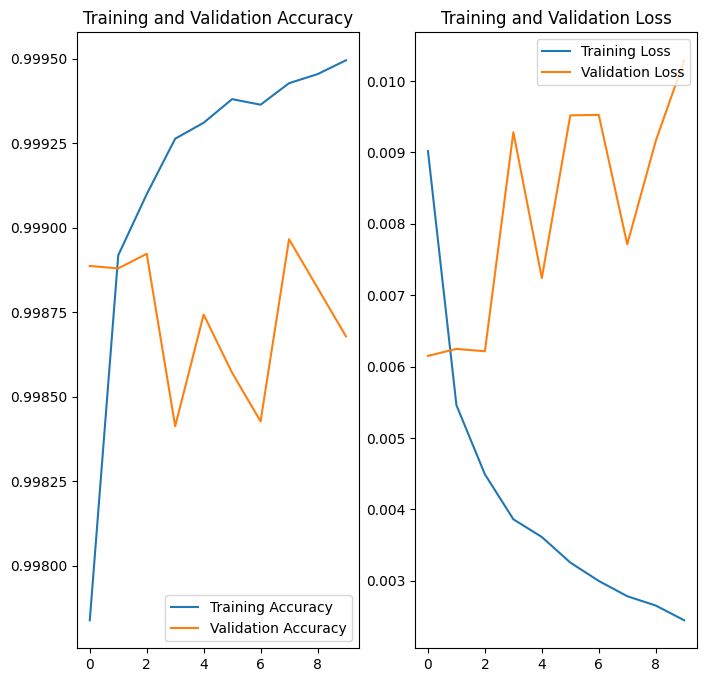

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Evaluate the model on the test dataset
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 69s 32ms/step - accuracy: 0.9988 - loss: 0.0086
Test Loss: 0.007873625494539738, Test Accuracy: 0.9988216757774353


In [ ]:
# Save the model in the native Keras format
model.save('/content/drive/My Drive/pklot_resnet50_model.keras')


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 67s 29ms/step


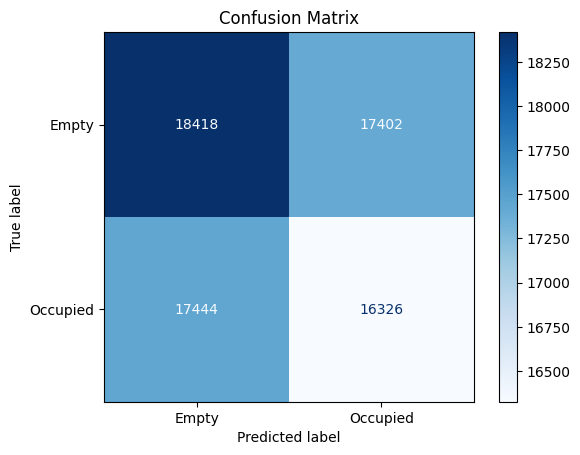

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Make predictions on the test set
test_predictions = model.predict(test_dataset)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to class labels

# 2. Get true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# 3. Generate the confusion matrix
cm = confusion_matrix(true_labels, test_predictions)

# 4. Plot the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Empty', 'Occupied']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


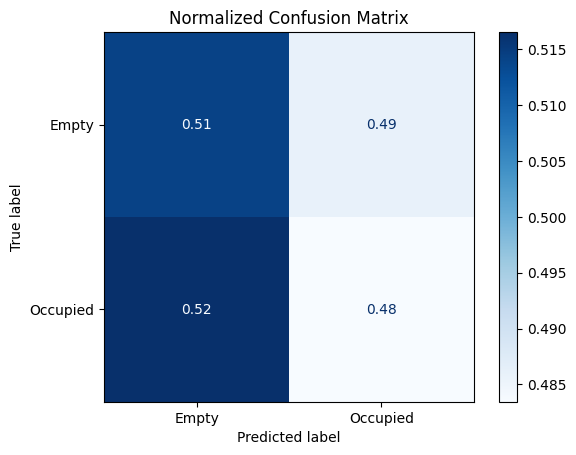

In [ ]:
cm = confusion_matrix(true_labels, test_predictions, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Empty', 'Occupied']).plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification report for precision, recall, and F1-score
print(classification_report(true_labels, test_predictions, target_names=['Empty', 'Occupied']))


              precision    recall  f1-score   support

       Empty       0.51      0.51      0.51     35820
    Occupied       0.48      0.48      0.48     33770

    accuracy                           0.50     69590
   macro avg       0.50      0.50      0.50     69590
weighted avg       0.50      0.50      0.50     69590

